This notebook shows the code for visualize keypoint detection, by loading from checkpoints (train.py).

In [43]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

In [44]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

def get_model(
        num_classes: int | None = None,
        num_keypoints: int | None = None
    ):
    # Load a pre-trained Keypoint RCNN model
    weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
    model = keypointrcnn_resnet50_fpn(weights=weights)

    # Modify the model's head
    if num_classes is not None:
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if num_keypoints is not None:
        in_features = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
        model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_features, num_keypoints)

    return model

def load_model_from_checkpoint(path: str):
    ckpt = torch.load(path, map_location=device)
    num_classes = ckpt["num_classes"] if "num_classes" in ckpt else None
    num_keypoints = ckpt["num_keypoints"] if "num_keypoints" in ckpt else None
    model = get_model(num_classes=num_classes, num_keypoints=num_keypoints).to(device)
    if "model_weight" in ckpt:
        model.load_state_dict(ckpt["model_weight"])
    return model

cuda


In [45]:
model = load_model_from_checkpoint("checkpoints/2025-12-12/15-07-04/epoch-48.pt")
model.eval()
print(type(model))

transforms = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT.transforms()
print(type(transforms))

<class 'torchvision.models.detection.keypoint_rcnn.KeypointRCNN'>
<class 'torchvision.transforms._presets.ObjectDetection'>


In [46]:
from PIL import Image

image = Image.open("images/jeans/001.jpg").convert("RGB")
image = transforms(image)
image = image.unsqueeze(0).to(device)
print(image.shape, image.dtype)

torch.Size([1, 3, 3000, 2400]) torch.float32


In [47]:
outputs = model(image)
print(outputs)

[{'boxes': tensor([[ 424.3559,  176.4446, 2018.4302, 2767.7646]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0', grad_fn=<IndexBackward0>), 'keypoints': tensor([[[7.3748e+02, 1.8394e+02, 1.0000e+00],
         [1.1929e+03, 2.7692e+02, 1.0000e+00],
         [1.6514e+03, 1.8394e+02, 1.0000e+00],
         [5.3672e+02, 9.9973e+02, 1.0000e+00],
         [4.8578e+02, 1.7915e+03, 1.0000e+00],
         [4.2885e+02, 2.7603e+03, 1.0000e+00],
         [8.8130e+02, 2.7603e+03, 1.0000e+00],
         [1.0191e+03, 1.7825e+03, 1.0000e+00],
         [1.2169e+03, 9.6974e+02, 1.0000e+00],
         [1.3667e+03, 1.6566e+03, 1.0000e+00],
         [1.5585e+03, 2.7603e+03, 1.0000e+00],
         [2.0139e+03, 2.7603e+03, 1.0000e+00],
         [1.9330e+03, 1.7345e+03, 1.0000e+00],
         [1.8551e+03, 9.9073e+02, 1.0000e+00]]], device='cuda:0',
       grad_fn=<CopySlices>), 'keypoints_scores': tensor([[15.0066, 17.1553, 14.95

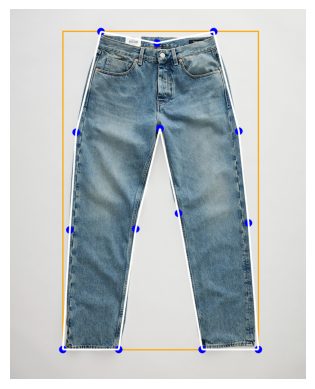

In [48]:
# Refer https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#visualizing-keypoints

from torchvision.utils import draw_keypoints, draw_bounding_boxes

idx = 0
image_single = (image[idx].cpu() * 255.0).to(torch.uint8)

mask = outputs[idx]["scores"] >= 0.8 # Apply threshold to score
boxes = outputs[idx]["boxes"][mask]

# Additional code for fixing local keypoints orientations
from roi_calib.custom.trousers import fix_trouser_orientation
keypoints = outputs[idx]["keypoints"][mask].cpu().detach().numpy()
keypoints = [fix_trouser_orientation(kypts) for kypts in keypoints]
keypoints = torch.tensor(keypoints)

keypoints, visibility = keypoints.split([2, 1], dim=-1)
visibility = visibility.bool()

# Refer DeepFashion2 trousers, but start from index 0
connect_skeleton = [
    (0, 3),
    *[(i, i+1) for i in range(3, 13)],
    (13, 2),
    (2, 1),
    (1, 0)
]

result_vis = draw_bounding_boxes(
    image=image_single,
    boxes=boxes,
    colors="orange",
    width=10
)

result_vis = draw_keypoints(
    image=result_vis,
    keypoints=keypoints,
    visibility=visibility,
    connectivity=connect_skeleton,
    colors="blue",
    radius=30,
    width=15,
)

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(result_vis.transpose(0, 2).transpose(0, 1))